# Analyse FUCCI data

Analyse FUCCI fluorescence data exported by TrackMate

We begin by importing the necessary packages:

In [21]:
import glob
import re  # Import the regular expression module
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

We then define some variables we'll be using later:

In [22]:
# Define constants
COLORS = ('blue', 'grey', 'orange', 'green', 'yellow')
FRAME_DURATION = 2
THRESHOLD = 0.05
WINDOW = 50

Next we define a function that we will use to detect a drop in fluorescence intensity:

In [23]:
# Function to find the frame with the steepest fall in intensity
def find_steep_fall_frame(intensity_values, threshold=THRESHOLD, window=WINDOW):
    max_fall = 0
    fall_frame = None

    for i in range(len(intensity_values) - window):
        fall = (intensity_values[i] - intensity_values[i + window]) / intensity_values[i]
        if fall > max_fall:
            max_fall = fall
            fall_frame = i

    return fall_frame if max_fall >= threshold else None

The `file_paths` variables holds the paths to all the source data we want to analyse, while the `frame_differences_all` variables will hold the resultant data that we are interested in plotting:

In [24]:
# Glob the file paths
file_paths = glob.glob(
    'Z:/working/Training/2024-Crick Microscopy Course/Live imaging/trial data/Prelim_analysis_2/Pos*/*_Pos*_spots.csv')

frame_differences_all = []
position_labels = []

# Regex to extract position number from file name
position_pattern = re.compile(r'_Pos(\d+)_')

The following loop does a number of things:
1. For each file path specified above, the dataset is read and relevant intensity data extracted
2. Within the next `for` loop, drops in fluorescence intensity are detected in each channel and the time difference between these drops calculated
3. Some summary statistics on the frame difference data is printed to the console

In [25]:
for file_path in file_paths:
    # Extract position number from file name
    match = position_pattern.search(file_path)
    position_num = -1
    if match:
        position_num = int(match.group(1))
        position_labels.append(position_num)
        
    data = pd.read_csv(file_path, skiprows=[1, 2, 3])
    data.sort_values(by=['TRACK_ID', 'FRAME'], ignore_index=True, inplace=True)
    intensity_data = data[['FRAME', 'TRACK_ID', 'MEAN_INTENSITY_CH2', 'MEAN_INTENSITY_CH3']]
    unique_tracks = intensity_data['TRACK_ID'].unique()
    
    frame_differences = []
    for track in unique_tracks:
        track_data = intensity_data[intensity_data['TRACK_ID'] == track]
        frames = track_data['FRAME'].values
        intensity_values_C2 = track_data['MEAN_INTENSITY_CH2'].values
        intensity_values_C3 = track_data['MEAN_INTENSITY_CH3'].values
        
        fall_frame_C3 = find_steep_fall_frame(intensity_values_C3)
        fall_frame_C2 = find_steep_fall_frame(intensity_values_C2)

        if fall_frame_C3 is not None and fall_frame_C2 is not None:
            frame_difference = (frames[fall_frame_C2] - frames[fall_frame_C3]) * FRAME_DURATION
            if frame_difference >= 0:
                frame_differences.append(frame_difference)
    
    frame_differences_all.append(frame_differences)
    
    # Output the statistics
    print(f"Mean Frame Difference (Pos {position_num}): {np.mean(frame_differences):.2f}")
    print(f"Median Frame Difference (Pos {position_num}): {np.median(frame_differences):.2f}")
    print(f"Standard Deviation of Frame Difference (Pos {position_num}): {np.std(frame_differences):.2f}")

Mean Frame Difference (Pos 0): 294.59
Median Frame Difference (Pos 0): 290.00
Standard Deviation of Frame Difference (Pos 0): 173.48
Mean Frame Difference (Pos 1): 257.21
Median Frame Difference (Pos 1): 272.00
Standard Deviation of Frame Difference (Pos 1): 122.37
Mean Frame Difference (Pos 4): 231.00
Median Frame Difference (Pos 4): 235.00
Standard Deviation of Frame Difference (Pos 4): 155.97
Mean Frame Difference (Pos 6): 211.84
Median Frame Difference (Pos 6): 218.00
Standard Deviation of Frame Difference (Pos 6): 185.23
Mean Frame Difference (Pos 7): 252.43
Median Frame Difference (Pos 7): 161.00
Standard Deviation of Frame Difference (Pos 7): 269.16


Finally, we plot the resulting distributions:

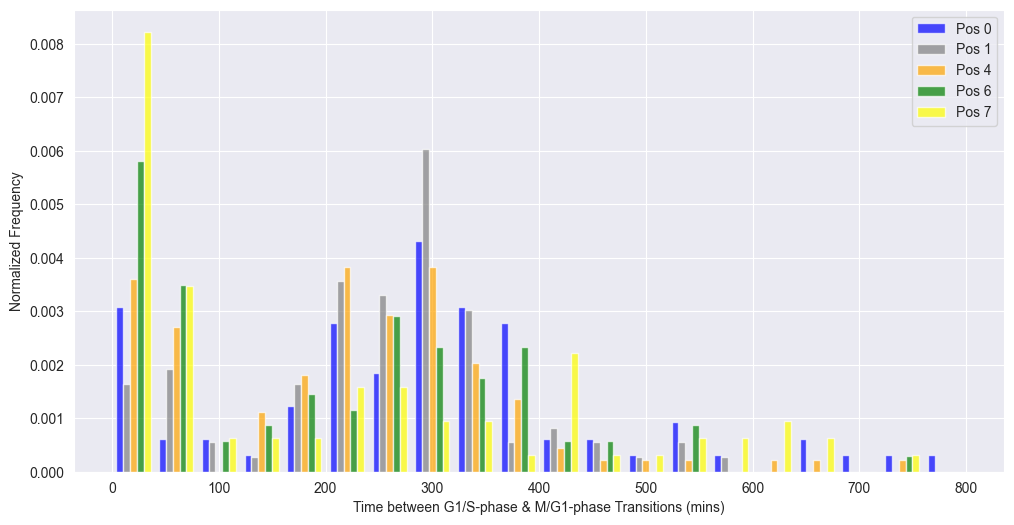

In [26]:
# Plotting
%matplotlib inline
plt.figure(figsize=(12, 6))

plt.hist(frame_differences_all, bins=20, range=(0, 800), color=COLORS[:len(frame_differences_all)], alpha=0.7, density=True,
         label=[f'Pos {pos}' for pos in position_labels])
plt.xlabel('Time between G1/S-phase & M/G1-phase Transitions (mins)')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

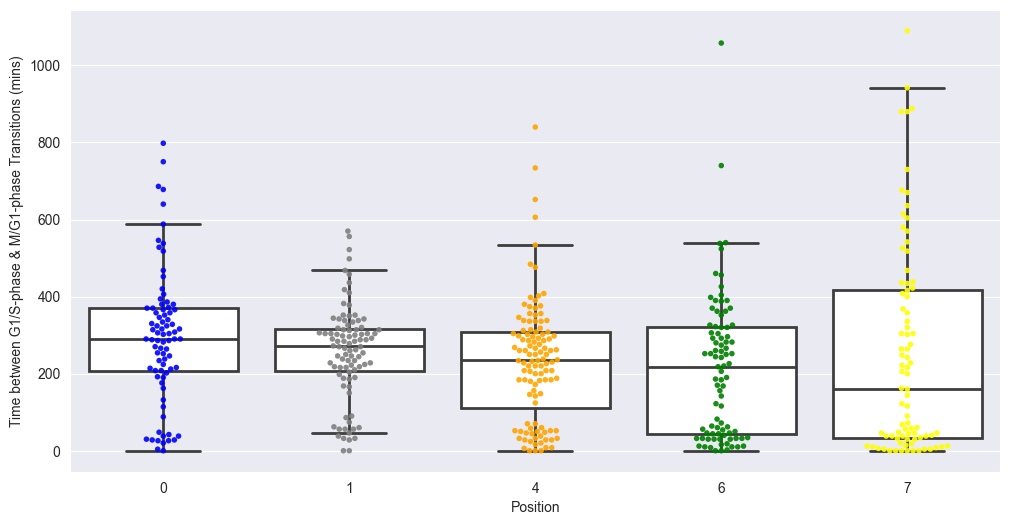

In [28]:
# Boxplot and Swarmplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=frame_differences_all, color='white', showfliers=False, ax=ax, linewidth=2)
sns.swarmplot(data=frame_differences_all, palette=COLORS[:len(frame_differences_all)], size=4, alpha=0.9, ax=ax)

# Set the ticks and labels
ax.set_xticks(range(len(position_labels)))  # Ensure the number of ticks matches the number of labels
ax.set_xticklabels(position_labels)

ax.set_ylabel('Time between G1/S-phase & M/G1-phase Transitions (mins)')
ax.set_xlabel('Position')
plt.show()